# B365 project: Bike Sharing Demand Prediction

## 0. Dataset introduction
This project is based on a fairly new dataset called Seoul Bike Sharing Demand Data Set (2020-3-11).
<br>Here is the source url: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#
Since this dataset is published March this year, it is within expectation that little reference can be found on the internet. So, we though it is a good chance to practice what we have learned in class on this dataset on our own.

<br>These are the attributes(14) for this dataset:
<br>Date : year-month-day 
<br>Rented Bike count - Count of bikes rented at each hour 
<br>Hour - Hour of he day 
<br>Temperature-Temperature in Celsius 
<br>Humidity - % 
<br>Windspeed - m/s 
<br>Visibility - 10m 
<br>Dew point temperature - Celsius 
<br>Solar radiation - MJ/m2 
<br>Rainfall - mm 
<br>Snowfall - cm 
<br>Seasons - Winter, Spring, Summer, Autumn 
<br>Holiday - Holiday/No holiday 
<br>Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

We need to predict the number of bikes rented per hour.
This is clearly a regression problem, so the models we choose are linear regression, polynomial regression, ridge regression, DecisionTreeRegressor, RandomForestRegressor and KNeighborsRegressor. 
We plan to use 5 cross validation and grid search on these models and compare them based on r2 score.
<br>Additionally, we will self implement linear regression with 5 cross validation use Normal equation method.
We will then compare that result with the linear regression model from sklearn library to prove our hypothesis that  normal equation and gradient descent yields the same result is correct.

## 1. Import Packages

In [1]:
import numpy as np    
import pandas as pd     
import matplotlib.pyplot as plt     
import seaborn as sns     
from sklearn.preprocessing import StandardScaler   # Standardize numirical data
from sklearn.preprocessing import PolynomialFeatures     # construct polynomial X
from sklearn.pipeline import make_pipeline        # combine PolynomialFeatures and linear regression
from sklearn.model_selection import GridSearchCV   # find best hypo paremeter
from sklearn.model_selection import KFold       # separate data to k fold
from sklearn.model_selection import cross_val_score   # preform cross validation to dataset
from sklearn.linear_model import Ridge       
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

## 2. Import Seoul Bike Sharing Demand Data Set

In [2]:
df = pd.read_csv("SeoulBikeData.csv",encoding= 'unicode_escape')
df.head()       

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.dtypes         # Seasons, Holiday and Functioning Day are objects.

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

In [4]:
df.isnull().sum()   # no null data

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

## 3. Preprocessing and Analysis Dataset
Since "Seasons", "Holiday" and "Functioning Day" are categorical variables, we need to change them to one hot econding.

In [5]:
df = df.drop(["Date"],axis=1)      # Date column is basicly useless, let's drop it.
# one-hot encoding: categorical variables change to varoables like 001 010 100.
df = pd.get_dummies(df, drop_first=True)

In [6]:
print(df.corr()['Rented Bike Count'].sort_values())    
# The dataset gets more sense to us when the correlation with Rented Bike Count get's clear.

Seasons_Winter              -0.424925
Humidity(%)                 -0.199780
Snowfall (cm)               -0.141804
Rainfall(mm)                -0.123074
Seasons_Spring               0.022888
Holiday_No Holiday           0.072338
Wind speed (m/s)             0.121108
Visibility (10m)             0.199280
Functioning Day_Yes          0.203943
Solar Radiation (MJ/m2)      0.261837
Seasons_Summer               0.296549
Dew point temperature(°C)    0.379788
Hour                         0.410257
Temperature(°C)              0.538558
Rented Bike Count            1.000000
Name: Rented Bike Count, dtype: float64


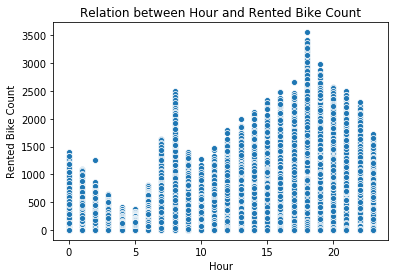

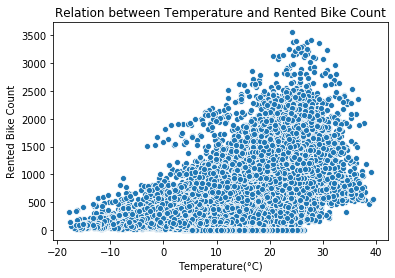

In [7]:
# Two typical relation graph
plt.title('Relation between Hour and Rented Bike Count')
sns.scatterplot(x=df['Hour'],y=df['Rented Bike Count'])
plt.show()
plt.title('Relation between Temperature and Rented Bike Count')
sns.scatterplot(x=df['Temperature(°C)'],y=df['Rented Bike Count'])
plt.show()

In [8]:
# prepare X and y
X = df.drop(['Rented Bike Count'], axis = 1)
y = df['Rented Bike Count']
# standardize X
sc = StandardScaler()
X = sc.fit_transform(X)

## 4. Decision Tree and Random Forest.
Using grid search and 5 cross validation to find the best hypo-parameters for Decision Tree and Random Forest.

In [9]:
DecTr_param = {
    "min_samples_split": [10, 15],        #15
    "max_depth": [12, 14],                #14
    "min_samples_leaf": [10],             #10
    "max_leaf_nodes": [180, 210, 250],    #250
}
DecTr_grid = GridSearchCV(DecisionTreeRegressor(), DecTr_param, cv=5)

DecTr_grid.fit(X,y)
best_DT = DecTr_grid.best_estimator_
best_DT # The best parameters

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=14,
                      max_features=None, max_leaf_nodes=250,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [10]:
RanForest_param = {
    'max_depth': [12,14],        #14
    'min_samples_leaf': [2],     #2
    'min_samples_split': [2],    #2
    'n_estimators': [100,120]    #100
}
RF_grid = GridSearchCV(RandomForestRegressor(), RanForest_param, cv=5)

RF_grid.fit(X,y.ravel())
best_RF = RF_grid.best_estimator_
best_RF

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## 5. Linear Regression Model.
Self implemented the linear regression with 5 cross validation use normal equation discussed in class.

In [11]:
def mylinearRegression(X,y):
    # theta = (inv(X.T*X))*X.T*y
    dim = X.shape
    b = np.ones((dim[0],1))
    X = np.concatenate([X,b],axis=1)
    a = np.linalg.inv(np.dot(X.T,X))
    b = np.dot(X.T,y)
    theta = np.dot(a,b)
    return theta

def lrpredict(X,theta):
    # y_hat = X*theta
    dim = X.shape
    b=np.ones((dim[0],1))
    X = np.concatenate([X,b],axis=1)
    return np.dot(X,theta)

# metrics mean square error, haven't been used in this project
def lrmse(yhat,y):
    # mse=||y_hat-y||^2 /n 
    num = len(y)
    error = np.sum((yhat-y)**2)/num 
    return error

# metrics R_square: 
# 1 - residual sum of square / total sum of squares
def lrr2(yhat,y):
    sse = np.sum((yhat - y)**2)
    sst = np.sum((y - y.mean())**2)
    r_square = 1 - (sse/sst)
    return r_square

In [12]:
kf = KFold(n_splits = 5, random_state=1, shuffle=True)
my_lr_r2score = []    #used to store 5 r2 scores
for train_idx, test_idx in kf.split(X, y):     # Every loop will generate one model and one r2 score
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    theta = mylinearRegression(X_train,y_train)
    yhat = lrpredict(X_test,theta)
    r2 = lrr2(yhat,y_test)
    my_lr_r2score.append(r2)
r2 = sum(my_lr_r2score)/len(my_lr_r2score)  # mean of five r2 score
print("Our self implemented linear regression with 5 fold cross validation r2 score is: \n", r2)

Our self implemented linear regression with 5 fold cross validation r2 score is: 
 0.548427216749686


## 6. Go through different regression models using sklearn library.
Though sklearn use gradient descent in linear regression to find theta, the idea behind it should be the same -- to minimize the MSE. The normal equation is more computational expansive since it inverse a matrix O(N^3). From the result, we saw our implementation of linear regression gives us the same answer with sklearn.

In [13]:
polyreg=make_pipeline(PolynomialFeatures(degree=2),LinearRegression())
lreg = LinearRegression()
ridge = Ridge(alpha=0.5)
KNN = KNeighborsRegressor()

lr = cross_val_score(lreg, X, y,scoring='r2', cv=kf)
lr = lr.mean()       # linear regression  r2:0.55   

polyr = cross_val_score(polyreg, X, y,scoring='r2', cv=kf)
polyr = polyr.mean()     # polynomial regression  r2:0.70

rig = cross_val_score(ridge, X, y, scoring='r2', cv=kf)
rig = rig.mean()        # ridge regression    r2:0.55

dt = cross_val_score(best_DT, X, y,scoring='r2', cv=kf)
dt = dt.mean()             # decision tree regression   r2:0.82

rf = cross_val_score(best_RF, X, y.ravel(),scoring='r2', cv=kf)
rf = rf.mean()          # Random Forest regression    r2:0.87 (best)

knn = cross_val_score(KNN, X, y,scoring='r2', cv=kf)
knn = knn.mean()     # K nearest neighbor      r2:0.79

## 7. Compare different models using r2 metric.
From the graph we saw that different model perform largely different.
<br>Random Forest Regression gives the best result, and Linear Regression gives the worst.
<br>Also,we find that normal equation yield the same result with gradient descent.

The r2 score for our self implemented linear regression is: 
 0.548427216749686

The r2 score for sklearn LinearRegression is the same:
 0.548427216749686

The r2 score for PloynomialRegression is:
 0.7005028838656342

The r2 score for Ridge Regression is:
 0.5484312051428192

The r2 score for DecisionTree is:
 0.8181496033489213

The r2 score for RandomForest is:
 0.8706696469780433

The r2 score for KNN is:
 0.785992040977317


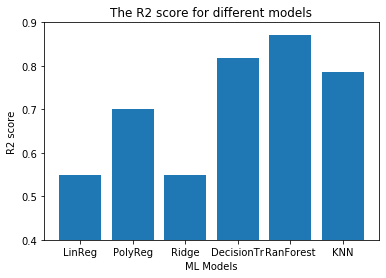

In [14]:
methods = ['LinReg','PolyReg','Ridge','DecisionTr','RanForest', 'KNN']
scores=np.array([lr,polyr,rig,dt,rf,knn])
ind = [x for x,_ in enumerate(methods)]
plt.bar(ind, scores)
plt.xticks(ind, methods)
plt.xlabel("ML Models")
plt.ylabel("R2 score")
plt.ylim(0.4,0.9)
plt.title("The R2 score for different models")

print("The r2 score for our self implemented linear regression is: \n", r2)
print('\nThe r2 score for sklearn LinearRegression is the same:\n', lr)
print('\nThe r2 score for PloynomialRegression is:\n', polyr)
print('\nThe r2 score for Ridge Regression is:\n', rig)
print('\nThe r2 score for DecisionTree is:\n', dt)
print('\nThe r2 score for RandomForest is:\n', rf)
print('\nThe r2 score for KNN is:\n', knn)